<a href="https://colab.research.google.com/github/darkwingpatil/Ml_hackethons/blob/main/Pytorch_Custom_Image_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

torch.__version__

'2.3.1+cu121'

### Getting data

In [ ]:
import requests
import zipfile
from pathlib import Path

In [ ]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path/ "hot_dog_no_hot_dog"

# If the image folder doesn't exist, creates it & download the data, prepare ...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download hot_dog_no_hot_dog data
    with open(data_path / "hot_dog_no_hot_dog.zip", "wb") as f:
        request = requests.get("http://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/hot_dog_no_hot_dog.zip")
        print("Downloading hot_dog_no_hot_dog data...")
        f.write(request.content)

    # Unzip the data
    with zipfile.ZipFile(data_path / "hot_dog_no_hot_dog.zip", "r") as zip_ref:
        print("Unzipping hot_dog_no_hot_dog data...")
        zip_ref.extractall(image_path)

Did not find data/hot_dog_no_hot_dog directory, creating one...
Unzipping hot_dog_no_hot_dog data...


In [ ]:
image_path

PosixPath('data/hot_dog_no_hot_dog')

### Data Preparation and Loading
* Data download is complete and we have data storage    now. The goal will be to take this data storage structure and turn it into a dataset usable with PyTorch.
* Inspecting what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present. To do so, we'll use Python's in-built os.walk().

In [ ]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/hot_dog_no_hot_dog'.
There are 2 directories and 0 images in 'data/hot_dog_no_hot_dog/train'.
There are 0 directories and 249 images in 'data/hot_dog_no_hot_dog/train/not_hot_dog'.
There are 0 directories and 249 images in 'data/hot_dog_no_hot_dog/train/hot_dog'.
There are 2 directories and 0 images in 'data/hot_dog_no_hot_dog/test'.
There are 0 directories and 250 images in 'data/hot_dog_no_hot_dog/test/not_hot_dog'.
There are 0 directories and 250 images in 'data/hot_dog_no_hot_dog/test/hot_dog'.



###  Visualize an image

/content/data/hot_dog_no_hot_dog/train/hot_dog/1000288.jpg

In [ ]:
import random
from PIL import Image

# Set seed
#random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

In [ ]:
image_path_list[0]

PosixPath('data/hot_dog_no_hot_dog/train/not_hot_dog/835998.jpg')

Random image path: data/hot_dog_no_hot_dog/test/not_hot_dog/59144.jpg
Image class: not_hot_dog
Image height: 384
Image width: 512


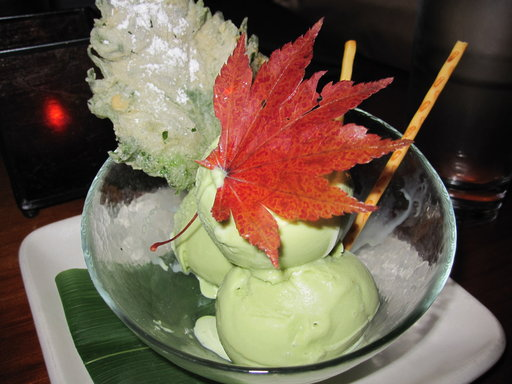

In [ ]:
# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

We can do the same with matplotlib.pyplot.imshow(), except we have to convert the image to a NumPy array first.

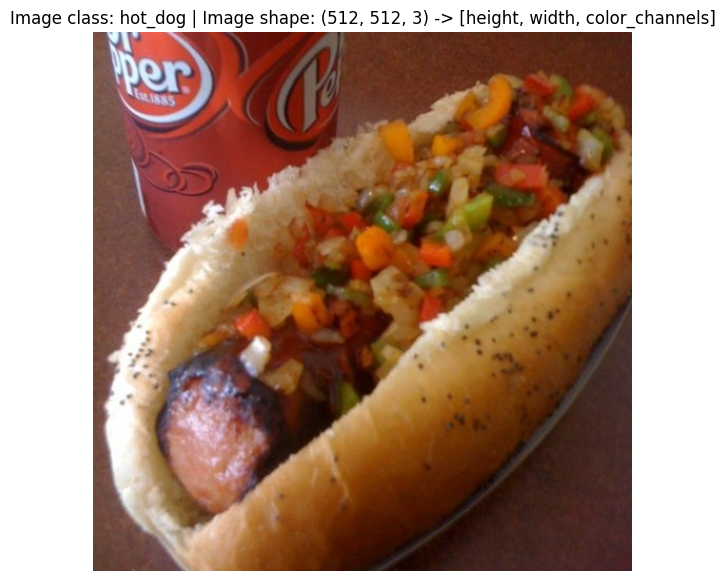

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)


# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

### Transforming data

Now what if we wanted to load our image data into PyTorch?

Before we can use our image data with PyTorch we need to:

    Turn it into tensors (numerical representations of our images).
    Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for short.

There are several different kinds of pre-built datasets and dataset loaders for PyTorch, depending on the problem you're working on. Since we're working with a vision problem, we'll be looking at ${torchvision.datasets}$ for our data loading functions as well as torchvision.transforms for preparing our data.

*  Setup train and test directory used later

In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/hot_dog_no_hot_dog/train'),
 PosixPath('data/hot_dog_no_hot_dog/test'))

#### Transforming data with torchvision.transforms

We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the torchvision.transforms module.

torchvision.transforms contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes .

To get experience with torchvision.transforms, let's write a series of transform steps that:
* Resize the images using transforms.Resize() (from about 512x512 to 64x64, the same shape ).
* Flip our images randomly on the horizontal using transforms.RandomHorizontalFlip() (this could be considered a form of data augmentation because it will artificially change our image data).
* Turn our images from a PIL image to a PyTorch tensor using transforms.ToTensor().

We can compile all of these steps using torchvision.transforms.Compose().

In [ ]:
# Let's import some base libraries.
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

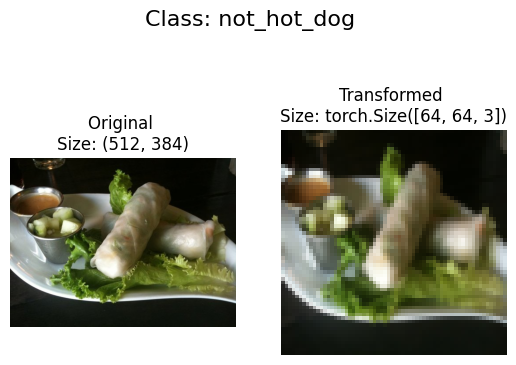

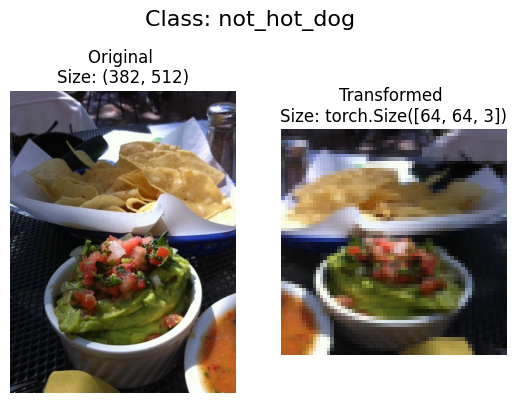

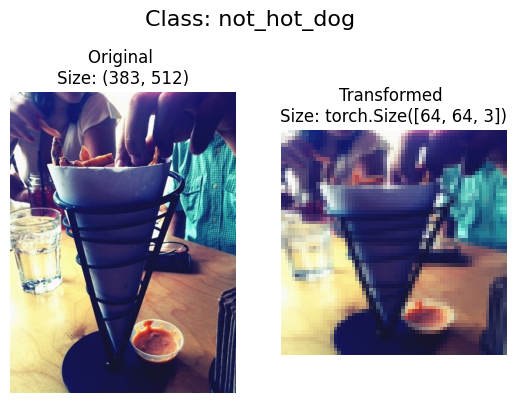

In [ ]:
plot_transformed_images(image_path_list, transform=data_transform, n=3)



Nice!

We've now got a way to convert our images to tensors using torchvision.transforms.

We also manipulate their size and orientation if needed (some models prefer images of different sizes and shapes).

Generally, the larger the shape of the image, the more information a model can recover.

For example, an image of size [256, 256, 3] will have 16x more pixels than an image of size [64, 64, 3] ((256*256*3)/(64*64*3)=16).

However, the tradeoff is that more pixels requires more computations.

    Exercise: Try commenting out one of the transforms in data_transform and running the plotting function plot_transformed_images() again, what happens?




### Loading Image Data with a Custom Dataset

What if a pre-built Dataset creator like torchvision.datasets.ImageFolder() didn't exist?

Or one for your specific problem didn't exist?

Well, you could build your own.

To see this in action, let's work towards replicating torchvision.datasets.ImageFolder() by subclassing torch.utils.data.Dataset (the base class for all Dataset's in PyTorch).

We'll start by importing the modules we need:


In [ ]:
import os  # deal with data directories
import pathlib # deals with filepaths (each of our images has a unique filepath).
import torch

from PIL import Image # class for loading images
from torch.utils.data import Dataset # to subclass and create our own custom Dataset.

from torchvision import transforms # to turn our images into tensors.
from typing import Tuple, Dict, List # module to add type hints to our code.


Remember how our instances of torchvision.datasets.ImageFolder() allowed us to use the classes and class_to_idx attributes?


train_data_all.classes, train_data_all.class_to_idx

results in:

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get class names

Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

To do so, we'll:

- Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).
- Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
- Turn the class names into a dictionary of numerical labels, one for each class.
Let's see a small example of step 1 before we write the full function.

In [ ]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


#### Now let's test out our find_classes() function

In [ ]:
find_classes(train_dir)

(['hot_dog', 'not_hot_dog'], {'hot_dog': 0, 'not_hot_dog': 1})


###  **Create a custom Dataset class to replicate ImageFolder**

Now we're ready to build our own custom Dataset.

We'll build one to replicate the functionality of torchvision.datasets.ImageFolder().

This will be good practice, plus, it'll reveal a few of the required steps to make your own custom Dataset.

It'll be a fair bit of a code... but nothing we can't handle!

Let's break it down:

- Subclass torch.utils.data.Dataset.
- Initialize our subclass with a targ_dir parameter (the target data directory) and transform parameter (so we have the option to transform our data if needed).
- Create several attributes for paths (the paths of our target images), transform (the transforms we might like to use, this can be None), classes and class_to_idx (from our find_classes() function).
- Create a function to load images from file and return them, this could be using PIL or torchvision.io (for input/output of vision data).
- Overwrite the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset, this is recommended but not required. This is so you can call len(Dataset).
- Overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required.


In [ ]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)


Woah! A whole bunch of code to load in our images.

This is one of the downsides of creating your own custom Dataset's.

However, now we've written it once, we could move it into a .py file such as data_loader.py along with some other helpful data functions and reuse it later on.

Before we test out our new ImageFolderCustom class, let's create some transforms to prepare our images.

In [ ]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


Now comes the moment of truth!

Let's turn our training images (contained in train_dir) and our testing images (contained in test_dir) into Dataset's using our own ImageFolderCustom class.

In [ ]:
train_data_all_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_all_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7e1a8d5321d0>,
 <__main__.ImageFolderCustom at 0x7e1a8d533970>)

Let's try calling len() on our new Dataset's and find the classes and class_to_idx attributes.

In [ ]:
len(train_data_all_custom), len(test_data_custom)

(498, 500)

In [ ]:
train_data_all_custom.classes

['hot_dog', 'not_hot_dog']

In [ ]:
class_names =train_data_all_custom.classes

In [ ]:
train_data_all_custom.class_to_idx

{'hot_dog': 0, 'not_hot_dog': 1}

In [ ]:
print(train_data_all_custom[100])
img, label = train_data_all_custom[100][0], train_data_all_custom[100][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

(tensor([[[0.8353, 0.7020, 0.6275,  ..., 0.7961, 0.7804, 0.7569],
         [0.7569, 0.6588, 0.6667,  ..., 0.8000, 0.7922, 0.7686],
         [0.8235, 0.8275, 0.8471,  ..., 0.7294, 0.7529, 0.7647],
         ...,
         [0.5922, 0.4980, 0.4824,  ..., 0.7098, 0.7020, 0.8078],
         [0.5765, 0.5412, 0.6235,  ..., 0.7529, 0.6627, 0.6980],
         [0.4549, 0.4941, 0.6314,  ..., 0.6902, 0.6235, 0.5804]],

        [[0.9216, 0.7686, 0.6784,  ..., 0.9137, 0.8941, 0.8784],
         [0.8431, 0.7294, 0.7255,  ..., 0.9137, 0.9059, 0.8863],
         [0.8941, 0.8902, 0.9098,  ..., 0.7882, 0.8431, 0.8824],
         ...,
         [0.3216, 0.2745, 0.2784,  ..., 0.7216, 0.7725, 0.9176],
         [0.3490, 0.3451, 0.4941,  ..., 0.8353, 0.7843, 0.8392],
         [0.3608, 0.3961, 0.5294,  ..., 0.8039, 0.7490, 0.7098]],

        [[0.7725, 0.6353, 0.5529,  ..., 0.8157, 0.7961, 0.7529],
         [0.6667, 0.5686, 0.5882,  ..., 0.8392, 0.8235, 0.7686],
         [0.7255, 0.7451, 0.7686,  ..., 0.7373, 0.7686, 0

### Creating validation set from train_all data

In [ ]:
from torch.utils.data import  random_split

valid_size=0.07
n_val = int(np.floor(valid_size * len(train_data_all_custom)))
n_train=len(train_data_all_custom)-n_val
print(n_train,',', n_val)

train_data_custom, valid_data_custom = random_split(train_data_all_custom, [n_train, n_val])

464 , 34


### Turn custom loaded images into DataLoader's¶
We've got a way to turn our raw images into Dataset's (features mapped to labels or X's mapped to y's) through our ImageFolderCustom class.

Now how could we turn our custom Dataset's into DataLoader's?

If you guessed by using torch.utils.data.DataLoader(), you'd be right!

Because our custom Dataset's subclass torch.utils.data.Dataset, we can use them directly with torch.utils.data.DataLoader().

And we can do using very similar steps to before except this time we'll be using our custom created Dataset's.

In [ ]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                              batch_size=10, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?
valid_dataloader_custom = DataLoader(dataset=valid_data_custom,
                             batch_size=3,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data


test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=5,
                                    num_workers=1,
                                    shuffle=False) # don't usually need to shuffle testing data



In [ ]:
(len(train_dataloader_custom), len(valid_dataloader_custom), len(test_dataloader_custom))

(47, 12, 100)

Do the shapes of the samples look the same?

In [ ]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([10, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([10])


#################

Our images are now in the form of a tensor (with shape [3, 64, 64]) and the labels are in the form of an integer relating to a specific class (as referenced by the class_to_idx attribute).

How about we plot a single image tensor using matplotlib?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format CHW (color channels, height, width) but matplotlib prefers HWC (height, width, color channels).


Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


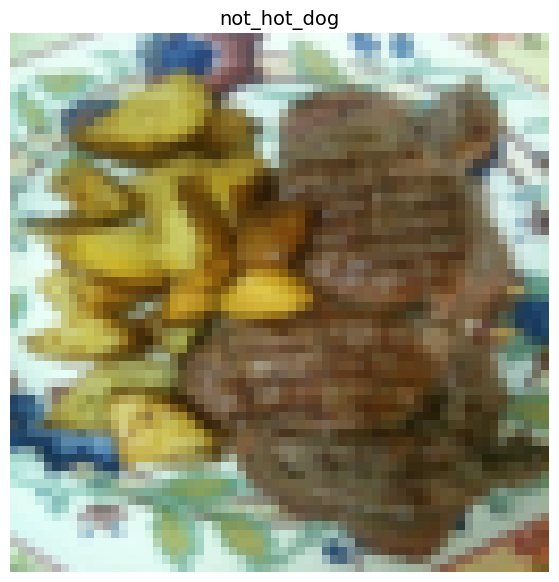

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

#### Building Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
......
............
..................